In [1]:
import json
import torch
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from torchvision.ops.boxes import box_iou

In [2]:
class PRCurveDrawer:
    def __init__(self,
        data_file: str=r'//aka/work/hara.e/AMED/lib/dataset/annotations/test.json',
        preds_file: str=r'//aka/work/hara.e/AMED/YOLOX/sample.json',
    ):

        with open(preds_file) as f:
            self.preds = json.load(f)
        with open(data_file) as f:
            self.data = json.load(f)['annotations']
        self.re_ths = [th / 100 for th in range(1, 101)]
        self.ious = self._get_ious()
        self.items = {'iou': self.ious, 'reliability': self.preds['reliability']}

    def draw(self, iou_th: list=[0.5]):
        self.iou_th = iou_th
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        
        for th in self.iou_th:
            precision, recall = self._get_pr(th)
            plt.plot(recall, list(reversed(precision)))

        plt.legend(self.iou_th, title='IoU')
        plt.xlabel('Recall')
        plt.ylabel('Precision')

    def _get_pr(self, iou_th: int):
        precision, recall = [], []
        for re_th in self.re_ths:
            currect = 0
            for iou, re in zip(self.items['iou'], self.items['reliability']):
                for i, r in zip(iou, re):
                    if (i > iou_th) and (r > re_th):
                        currect += 1
            recall += [currect / len(self.items['iou'])]
            precision += [currect / len([i for item in self.items['iou'] for i in item])]
        return precision, recall
    
    def _get_reliability(self):
        return self.preds['reliability']
            
    def _get_ious(self):
        ious = []
        for i, pred in enumerate(self.preds['annotations']):
            iou = self._calc_iou(self.preds['annotations'][i], self.data[i]['bbox'])
            ious += [iou]
        return ious
        
    def _calc_iou(self, pred: list, label: list):
        x, y, w, h = label
        if pred is not None:
            iou = box_iou(torch.Tensor(pred['bbox']), torch.Tensor([[x, y, x + w, y + h]]))
        else:
            iou = torch.Tensor([[0.]])
        return iou.flatten().tolist()

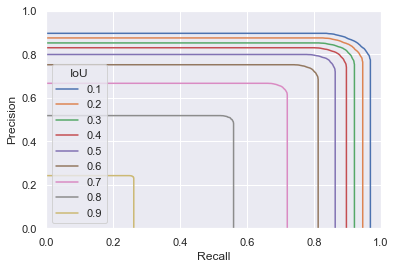

In [3]:
drawer = PRCurveDrawer()
drawer.draw(iou_th = [th / 10 for th in range(1, 10)])